# Low-Dimensional Representation Using Autoencoder

## Getting the Data

In [3]:
import warnings
warnings.filterwarnings("ignore")
import sys
from herdingspikes.hs2 import HSDetection
from herdingspikes.probe import HierlmannVisapyEmulationProbe
import matplotlib.pyplot as plt
import h5py
import numpy as np

np.random.seed(0)

In [2]:
import urllib
file_url = 'https://datasync.ed.ac.uk/public.php/webdav'

password_mgr = urllib.request.HTTPPasswordMgrWithDefaultRealm()
password_mgr.add_password(None, file_url, "GbnXJ5bU3m9JPau", "HS2")
handler = urllib.request.HTTPBasicAuthHandler(password_mgr)
opener = urllib.request.build_opener(handler)
opener.open(file_url)
urllib.request.install_opener(opener)
with urllib.request.urlopen(file_url) as response, open('visapy_data.npy', 'wb') as out_file:
    data = response.read()
    out_file.write(data)

# raw data location
data_path = 'visapy_data.npy'

KeyboardInterrupt: 

In [4]:
# detection parameters
to_localize = False
cutout_start = 14
cutout_end = 36
threshold = 24
file_directory = 'results/'
file_name = 'ProcessedSpikes_visapy'

In [5]:
Probe = HierlmannVisapyEmulationProbe('visapy_data.npy')
H = HSDetection(Probe, to_localize, cutout_start, cutout_end, threshold,
                maa=0, maxsl=12, minsl=3, ahpthr=0, out_file_name=file_name, 
                file_directory_name=file_directory, save_all=True)

File size: 122400102
Number of channels: 102


## Detecting Spikes

In [6]:
H.DetectFromRaw()

# Sampling rate: 32000
# Localization Off
# Not Masking any Channels
# Writing out extended detection info
# Number of recorded channels: 102
# Analysing frames: 1200001, Seconds:37.50003125
# Frames before spike in cutout: 32
# Frames after spike in cutout: 70
# tcuts: 44 59
# tInc: 50000
# Analysing 50000 frames; from -44 to 50059
# Analysing 50000 frames; from 49956 to 100059
# Analysing 50000 frames; from 99956 to 150059
# Analysing 50000 frames; from 149956 to 200059
# Analysing 50000 frames; from 199956 to 250059
# Analysing 50000 frames; from 249956 to 300059
# Analysing 50000 frames; from 299956 to 350059
# Analysing 50000 frames; from 349956 to 400059
# Analysing 50000 frames; from 399956 to 450059
# Analysing 50000 frames; from 449956 to 500059
# Analysing 50000 frames; from 499956 to 550059
# Analysing 50000 frames; from 549956 to 600059
# Analysing 50000 frames; from 599956 to 650059
# Analysing 50000 frames; from 649956 to 700059
# Analysing 50000 frames; from 699956 to 75

In [7]:
H.LoadDetected()

Detected and read 19341 spikes.


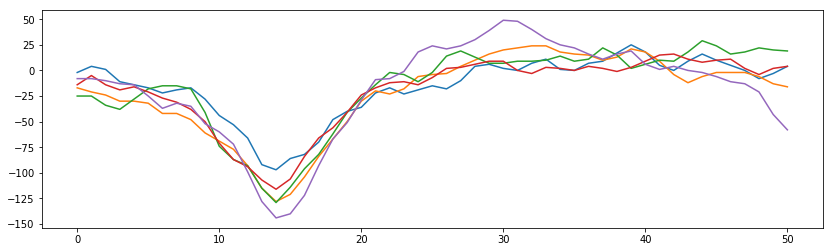

In [8]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(14,4))
for i in [14, 18, 77, 90, 156]:
    plt.plot(H.spikes['Shape'][i])
plt.show()
    

In [9]:
length = H.spikes['Shape'][0].shape[0]
total_sigs = H.spikes['Shape'].shape[0]
embedding_size = (int)(length//4)

electrode_data = np.zeros([total_sigs, length])
list_of_sigs = np.random.choice(total_sigs, total_sigs, replace=False)

for i in list_of_sigs:
    electrode_data[i, :] = H.spikes['Shape'][i]
print(electrode_data.shape)

(19341, 51)


In [10]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=12)
# pca.fit(electrode_data)
# e_data_pca = pca.transform(electrode_data_train)
# e_data_proj = pca.inverse_transform(e_data_pca)

In [11]:
# plt.figure(figsize=(14,4))

# n = [3490, 1098, 2377, 9, 871]

# for i in n:
#     plt.subplot(121)
#     plt.plot(electrode_data_test[i, :])
#     plt.title('Original')
#     plt.xlabel('Time')
#     plt.ylabel('Amplitude')
#     plt.subplot(122)
#     plt.plot(e_data_proj[i, :])
#     plt.title('PCA reconstruction')
#     plt.xlabel('Time')
#     plt.ylabel('Amplitude')
# plt.show()

## Scaling data between 0 and 1

In [11]:
# electrode_data = electrode_data_temp[:, :]

In [12]:
# max_val = np.amax(electrode_data)
# min_val = np.amin(electrode_data)
# span = max_val - min_val
# electrode_data = (electrode_data - min_val)/span

In [12]:
print(electrode_data)

[[ -7.  -2.   4. ...   7.   7.   9.]
 [ 35.  33.  26. ...   0.  -7. -10.]
 [ 15.  16.   8. ... -11.  -1.   1.]
 ...
 [ -2. -19. -23. ...  -7. -15. -31.]
 [ 12.   0.  -3. ...  -8. -10.  -5.]
 [-20. -32. -29. ...   9.   0.  -9.]]


## Designing the AutoEncoder 

In [22]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils import data
import random

torch.cuda.set_device(2)
torch.manual_seed(0)

In [23]:
class generator(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(generator, self).__init__()
        activation_layer = nn.PReLU()
        self.encoder = nn.Sequential(nn.Linear(input_size, 100),
                                     activation_layer,
                                     nn.Linear(100, 50),
                                     activation_layer,
                                     nn.Linear(50, 25),
                                     activation_layer,
                                     nn.Linear(25, 80),
                                     activation_layer,
                                     nn.Linear(80, 28),
                                     activation_layer,
                                     nn.Linear(28, embedding_size))
        self.decoder = nn.Sequential(nn.Linear(embedding_size, 16),
                                     activation_layer,
                                     nn.Linear(16, 25),
                                     activation_layer,
                                     nn.Linear(25, input_size))
    
    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        return enc, dec

In [24]:
class discriminator(nn.Module):
    def __init__(self, input_size):
        super(discriminator, self).__init__()
        self.detect = nn.Sequential(nn.Linear(input_size, 32),
                                    nn.ELU(),
                                    nn.Linear(32, 16),
                                    nn.ELU(),
                                    nn.Linear(16, 4),
                                    nn.ELU(),
                                    nn.Linear(4, 1),
                                    nn.Sigmoid())
    def forward(self, x):
        out = self.detect(x)
        return out

## Splitting the data into Train and Test

In [25]:
train_lim = int(0.8*electrode_data.shape[0])
electrode_data_train = electrode_data[:train_lim, :]
electrode_data_test = electrode_data[train_lim:, :]

print("Training Datasize:", electrode_data_train.shape)
print("Test Datasize:", electrode_data_test.shape)

Training Datasize: (15472, 51)
Test Datasize: (3869, 51)


In [26]:
# Using Trick 4 - Diffferent mini-batches of real and fake data for training

def train_gan(disc, gen, input_data, d_criterion, g_criterion, d_optimizer, g_optimizer, epoch_range,  
              batch_size_d, batch_size_g):
    random.seed(0)
    losses = []
    for num_epoch in range(epoch_range):
        
        d_selected = random.sample(range(0, input_data.shape[0]), batch_size_d)

        for feats in d_selected:
            #---------Training the discriminator on real data------#
            real_data = input_data[feats, :]
            real_data = torch.from_numpy(real_data).float().cuda()
            #---------FORWARD------------#
            real_decision = disc.forward(real_data)
            real_decision = torch.tensor(real_decision).float().cuda()
            real_loss = d_criterion(real_decision, Variable(torch.ones(1)).cuda())
            #---------BACKWARD------------#
            real_loss.backward()
            
            d_optimizer.zero_grad()            
            d_optimizer.step()
        
        d_selected = random.sample(range(0, input_data.shape[0]), batch_size_d)
        
        for feats in d_selected:
            
            #---------Training the discriminator on fake data------#
            enc, fake_data = gen.forward(real_data)
            fake_data = torch.tensor(fake_data).float().cuda()
            #---------FORWARD------------#
            fake_decision = disc.forward(fake_data)
            fake_decision = torch.tensor(fake_decision).float().cuda()
            fake_loss = d_criterion(fake_decision, Variable(torch.zeros(1)).cuda())
            #---------BACKWARD------------#
            fake_loss.backward()
            
            d_optimizer.zero_grad()            
            d_optimizer.step()
        
        g_selected = random.sample(range(0, input_data.shape[0]), batch_size_g)
        
        for feats in g_selected:
            x = input_data[feats, :]
            x = torch.from_numpy(x).float().cuda()
            #---------FORWARD------------#
            enc, out = gen.forward(x)
            out = torch.tensor(out).float().cuda()
            g_loss = g_criterion(out, x)
            #---------BACKWARD------------#
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
        print('epoch [{}/{}], disc_real_loss:{:.4f}, disc_fake_loss:{:.4f}, gen_loss:{:.4f}'.format(num_epoch + 1, 
                                                    epoch_range, real_loss.data[0], fake_loss.data[0], g_loss.data[0]))
        losses.append(g_loss.data[0])
    return enc, out, losses

In [27]:
def init_gan_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)

## Training with embedding size = 12

In [22]:
epoch_range = 500
batch_size_d = 150
batch_size_g = 100
g_learning_rate = 0.0001
d_learning_rate = 0.0001
embedding_size = 12

# Defining the models
gen_1 = generator(length, embedding_size).cuda()
disc_1 = discriminator(length).cuda()

# Initialising the weights
gen_1.apply(init_gan_weights)
disc_1.apply(init_gan_weights)

# Setting up the loss criteria
g_criterion = nn.MSELoss()
d_criterion = nn.BCELoss()

# Setting up the Optimizer (Using Adam here)
g_optimizer = torch.optim.Adam(
    gen_1.parameters(), lr=g_learning_rate, weight_decay=0.001)
d_optimizer = torch.optim.Adam(
    disc_1.parameters(), lr=d_learning_rate, weight_decay=0.001)

enc, out, losses_1 = train_gan(disc_1, gen_1, electrode_data_train, d_criterion, g_criterion, 
                             d_optimizer, g_optimizer, epoch_range, batch_size_d, batch_size_g)

epoch [1/500], disc_real_loss:4.3575, disc_fake_loss:0.3049, gen_loss:2960.2637
epoch [2/500], disc_real_loss:2.7422, disc_fake_loss:0.5613, gen_loss:1911.0184
epoch [3/500], disc_real_loss:2.3658, disc_fake_loss:0.4428, gen_loss:827.6970
epoch [4/500], disc_real_loss:2.1675, disc_fake_loss:0.5436, gen_loss:176.2089
epoch [5/500], disc_real_loss:1.1863, disc_fake_loss:0.5134, gen_loss:170.4267
epoch [6/500], disc_real_loss:0.9751, disc_fake_loss:0.5095, gen_loss:264.1331
epoch [7/500], disc_real_loss:0.5837, disc_fake_loss:0.5029, gen_loss:216.9957
epoch [8/500], disc_real_loss:1.0855, disc_fake_loss:0.4982, gen_loss:90.7444
epoch [9/500], disc_real_loss:0.8615, disc_fake_loss:0.5075, gen_loss:86.9171
epoch [10/500], disc_real_loss:0.9662, disc_fake_loss:0.5737, gen_loss:139.9416
epoch [11/500], disc_real_loss:0.8983, disc_fake_loss:0.5323, gen_loss:58.6449
epoch [12/500], disc_real_loss:0.9502, disc_fake_loss:0.5304, gen_loss:196.4631
epoch [13/500], disc_real_loss:0.7927, disc_fake_l

epoch [104/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:112.1244
epoch [105/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:62.4167
epoch [106/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:42.9880
epoch [107/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:116.2582
epoch [108/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:57.5228
epoch [109/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:252.8379
epoch [110/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:81.0759
epoch [111/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:56.8541
epoch [112/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:60.6976
epoch [113/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:61.2421
epoch [114/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:263.9933
epoch [115/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:74.9124
epoch [116/500], disc_real_loss:0.69

epoch [207/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:96.5516
epoch [208/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:102.2614
epoch [209/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:29.7606
epoch [210/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:48.3596
epoch [211/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:34.6656
epoch [212/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:55.3149
epoch [213/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:50.5846
epoch [214/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:34.0872
epoch [215/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:70.8080
epoch [216/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:72.2567
epoch [217/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:26.9886
epoch [218/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:45.1770
epoch [219/500], disc_real_loss:0.6931,

epoch [310/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:44.7141
epoch [311/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:30.0964
epoch [312/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:48.7997
epoch [313/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:39.8179
epoch [314/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:70.2059
epoch [315/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:36.4808
epoch [316/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:56.4564
epoch [317/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:43.6956
epoch [318/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:48.8699
epoch [319/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:56.7409
epoch [320/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:35.8310
epoch [321/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:40.2169
epoch [322/500], disc_real_loss:0.6931, 

epoch [413/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:21.7129
epoch [414/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:27.9147
epoch [415/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:41.0417
epoch [416/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:63.1242
epoch [417/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:50.8291
epoch [418/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:40.0085
epoch [419/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:47.7720
epoch [420/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:40.9927
epoch [421/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:38.3151
epoch [422/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:66.4449
epoch [423/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:59.9159
epoch [424/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:39.1533
epoch [425/500], disc_real_loss:0.6931, 

In [23]:
torch.save(gen_1, 'models/visapy/gan_12.pt') #Saving the autoencoder model

## Loss Plot and Reconstruction

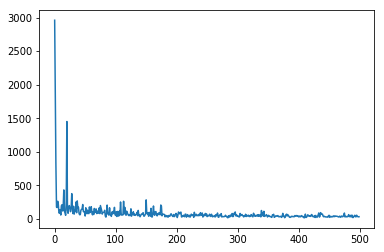

In [24]:
plt.figure()
plt.plot(losses_1)
plt.show()

## Training with embedding size = 10

In [25]:
epoch_range = 500
batch_size_d = 150
batch_size_g = 100
g_learning_rate = 0.0001
d_learning_rate = 0.0001
embedding_size = 10

# Defining the models
gen_2 = generator(length, embedding_size).cuda()
disc_2 = discriminator(length).cuda()

# Initialising the weights
gen_2.apply(init_gan_weights)
disc_2.apply(init_gan_weights)

# Setting up the loss criteria
g_criterion = nn.MSELoss()
d_criterion = nn.BCELoss()

# Setting up the Optimizer (Using Adam here)
g_optimizer = torch.optim.Adam(
    gen_2.parameters(), lr=g_learning_rate, weight_decay=0.001)
d_optimizer = torch.optim.Adam(
    disc_2.parameters(), lr=d_learning_rate, weight_decay=0.001)

enc, out, losses_2 = train_gan(disc_2, gen_2, electrode_data_train, d_criterion, g_criterion, 
                             d_optimizer, g_optimizer, epoch_range, batch_size_d, batch_size_g)

epoch [1/500], disc_real_loss:14.3630, disc_fake_loss:1.0878, gen_loss:2557.4121
epoch [2/500], disc_real_loss:1.5608, disc_fake_loss:0.3161, gen_loss:1505.8734
epoch [3/500], disc_real_loss:1.5581, disc_fake_loss:2.2830, gen_loss:530.5565
epoch [4/500], disc_real_loss:1.4362, disc_fake_loss:2.8104, gen_loss:134.9492
epoch [5/500], disc_real_loss:1.3785, disc_fake_loss:1.6528, gen_loss:178.5159
epoch [6/500], disc_real_loss:0.9749, disc_fake_loss:0.9498, gen_loss:274.9305
epoch [7/500], disc_real_loss:0.6209, disc_fake_loss:0.9399, gen_loss:183.1572
epoch [8/500], disc_real_loss:0.7167, disc_fake_loss:0.9497, gen_loss:83.2370
epoch [9/500], disc_real_loss:0.5223, disc_fake_loss:0.8191, gen_loss:71.4473
epoch [10/500], disc_real_loss:0.7701, disc_fake_loss:0.7397, gen_loss:131.4436
epoch [11/500], disc_real_loss:0.6032, disc_fake_loss:0.7373, gen_loss:59.4095
epoch [12/500], disc_real_loss:0.7025, disc_fake_loss:0.7308, gen_loss:158.5208
epoch [13/500], disc_real_loss:0.6238, disc_fake_

epoch [105/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:58.8521
epoch [106/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:43.7062
epoch [107/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:97.5605
epoch [108/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:64.2658
epoch [109/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:164.9371
epoch [110/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:63.3283
epoch [111/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:50.4334
epoch [112/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:36.1098
epoch [113/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:57.4282
epoch [114/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:249.5096
epoch [115/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:55.3632
epoch [116/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:200.0598
epoch [117/500], disc_real_loss:0.693

epoch [208/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:109.1894
epoch [209/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:28.8155
epoch [210/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:56.1274
epoch [211/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:27.7956
epoch [212/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:51.6050
epoch [213/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:48.5952
epoch [214/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:31.6621
epoch [215/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:72.8710
epoch [216/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:54.6836
epoch [217/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:25.7153
epoch [218/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:56.2973
epoch [219/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:48.1233
epoch [220/500], disc_real_loss:0.6931,

epoch [311/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:34.6849
epoch [312/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:57.2865
epoch [313/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:42.6032
epoch [314/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:62.3630
epoch [315/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:29.1180
epoch [316/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:46.0393
epoch [317/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:37.1348
epoch [318/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:46.1120
epoch [319/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:45.1747
epoch [320/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:52.4651
epoch [321/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:43.2061
epoch [322/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:36.4125
epoch [323/500], disc_real_loss:0.6931, 

epoch [414/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:24.2398
epoch [415/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:37.4164
epoch [416/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:55.5441
epoch [417/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:43.2843
epoch [418/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:42.5391
epoch [419/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:46.6843
epoch [420/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:47.9750
epoch [421/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:30.0111
epoch [422/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:78.2707
epoch [423/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:41.0964
epoch [424/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:37.6054
epoch [425/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:37.3777
epoch [426/500], disc_real_loss:0.6931, 

In [26]:
torch.save(gen_2, 'models/visapy/gan_10.pt') #Saving the autoencoder model

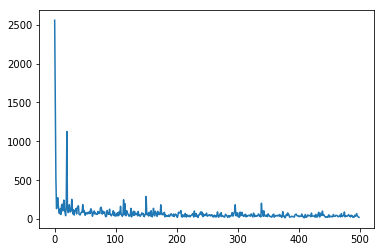

In [27]:
plt.figure()
plt.plot(losses_2)
plt.show()

## Training with embedding size = 8

In [28]:
epoch_range = 500
batch_size_d = 150
batch_size_g = 100
g_learning_rate = 0.0001
d_learning_rate = 0.0001
embedding_size = 8

# Defining the models
gen_3 = generator(length, embedding_size).cuda()
disc_3 = discriminator(length).cuda()

# Initialising the weights
gen_3.apply(init_gan_weights)
disc_3.apply(init_gan_weights)

# Setting up the loss criteria
g_criterion = nn.MSELoss()
d_criterion = nn.BCELoss()

# Setting up the Optimizer (Using Adam here)
g_optimizer = torch.optim.Adam(
    gen_3.parameters(), lr=g_learning_rate, weight_decay=0.001)
d_optimizer = torch.optim.Adam(
    disc_3.parameters(), lr=d_learning_rate, weight_decay=0.001)

enc, out, losses_3 = train_gan(disc_3, gen_3, electrode_data_train, d_criterion, g_criterion, 
                             d_optimizer, g_optimizer, epoch_range, batch_size_d, batch_size_g)

epoch [1/500], disc_real_loss:27.6310, disc_fake_loss:0.7515, gen_loss:2528.2778
epoch [2/500], disc_real_loss:27.6310, disc_fake_loss:0.0000, gen_loss:1413.5094
epoch [3/500], disc_real_loss:27.6310, disc_fake_loss:0.0000, gen_loss:664.9932
epoch [4/500], disc_real_loss:27.6310, disc_fake_loss:0.0000, gen_loss:210.6665
epoch [5/500], disc_real_loss:24.1069, disc_fake_loss:0.0000, gen_loss:190.1506
epoch [6/500], disc_real_loss:7.0131, disc_fake_loss:0.0002, gen_loss:254.5472
epoch [7/500], disc_real_loss:9.9272, disc_fake_loss:0.0002, gen_loss:201.0546
epoch [8/500], disc_real_loss:11.2322, disc_fake_loss:0.0001, gen_loss:87.4260
epoch [9/500], disc_real_loss:3.9221, disc_fake_loss:0.0183, gen_loss:83.6058
epoch [10/500], disc_real_loss:3.3730, disc_fake_loss:0.1413, gen_loss:141.5417
epoch [11/500], disc_real_loss:2.0518, disc_fake_loss:0.1853, gen_loss:58.9622
epoch [12/500], disc_real_loss:1.9925, disc_fake_loss:0.2060, gen_loss:174.4585
epoch [13/500], disc_real_loss:1.3387, disc_

epoch [104/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:124.6785
epoch [105/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:59.1001
epoch [106/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:44.5201
epoch [107/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:71.8050
epoch [108/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:65.7019
epoch [109/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:159.0633
epoch [110/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:61.9064
epoch [111/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:52.1641
epoch [112/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:54.8551
epoch [113/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:61.4958
epoch [114/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:267.0912
epoch [115/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:68.2352
epoch [116/500], disc_real_loss:0.693

epoch [207/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:86.8554
epoch [208/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:94.5766
epoch [209/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:31.6547
epoch [210/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:58.3024
epoch [211/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:28.6585
epoch [212/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:50.8565
epoch [213/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:60.0706
epoch [214/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:43.2308
epoch [215/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:67.2994
epoch [216/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:80.2713
epoch [217/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:28.1306
epoch [218/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:50.8381
epoch [219/500], disc_real_loss:0.6931, 

epoch [310/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:47.7507
epoch [311/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:31.6303
epoch [312/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:50.7863
epoch [313/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:44.3242
epoch [314/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:67.0669
epoch [315/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:30.6890
epoch [316/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:58.7241
epoch [317/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:46.6003
epoch [318/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:49.6065
epoch [319/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:51.7513
epoch [320/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:42.8890
epoch [321/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:42.8072
epoch [322/500], disc_real_loss:0.6931, 

epoch [413/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:41.3166
epoch [414/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:30.3143
epoch [415/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:36.2402
epoch [416/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:66.9454
epoch [417/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:57.8627
epoch [418/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:43.2160
epoch [419/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:44.1717
epoch [420/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:44.8397
epoch [421/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:46.4696
epoch [422/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:67.4250
epoch [423/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:62.5245
epoch [424/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:46.2871
epoch [425/500], disc_real_loss:0.6931, 

In [29]:
torch.save(gen_3, 'models/visapy/gan_8.pt') #Saving the autoencoder model

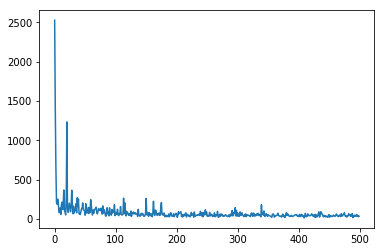

In [30]:
plt.figure()
plt.plot(losses_3)
plt.show()

## Training with embedding size = 6

In [31]:
epoch_range = 500
batch_size_d = 150
batch_size_g = 100
g_learning_rate = 0.0001
d_learning_rate = 0.0001
embedding_size = 6

# Defining the models
gen_4 = generator(length, embedding_size).cuda()
disc_4 = discriminator(length).cuda()

# Initialising the weights
gen_4.apply(init_gan_weights)
disc_4.apply(init_gan_weights)

# Setting up the loss criteria
g_criterion = nn.MSELoss()
d_criterion = nn.BCELoss()

# Setting up the Optimizer (Using Adam here)
g_optimizer = torch.optim.Adam(
    gen_4.parameters(), lr=g_learning_rate, weight_decay=0.001)
d_optimizer = torch.optim.Adam(
    disc_4.parameters(), lr=d_learning_rate, weight_decay=0.001)

enc, out, losses_4 = train_gan(disc_4, gen_4, electrode_data_train, d_criterion, g_criterion, 
                             d_optimizer, g_optimizer, epoch_range, batch_size_d, batch_size_g)

epoch [1/500], disc_real_loss:0.0975, disc_fake_loss:0.1303, gen_loss:2831.2725
epoch [2/500], disc_real_loss:0.0002, disc_fake_loss:0.1915, gen_loss:1972.9197
epoch [3/500], disc_real_loss:2.2031, disc_fake_loss:0.0080, gen_loss:1158.2552
epoch [4/500], disc_real_loss:0.9108, disc_fake_loss:0.0152, gen_loss:383.9037
epoch [5/500], disc_real_loss:0.8555, disc_fake_loss:0.3212, gen_loss:190.6923
epoch [6/500], disc_real_loss:0.9163, disc_fake_loss:0.5074, gen_loss:293.0257
epoch [7/500], disc_real_loss:0.8537, disc_fake_loss:0.5082, gen_loss:214.8117
epoch [8/500], disc_real_loss:0.8323, disc_fake_loss:0.5135, gen_loss:94.1386
epoch [9/500], disc_real_loss:0.9520, disc_fake_loss:0.5448, gen_loss:87.4768
epoch [10/500], disc_real_loss:0.7269, disc_fake_loss:0.5874, gen_loss:141.2532
epoch [11/500], disc_real_loss:0.7898, disc_fake_loss:0.6150, gen_loss:64.6222
epoch [12/500], disc_real_loss:0.7233, disc_fake_loss:0.6292, gen_loss:197.4331
epoch [13/500], disc_real_loss:0.7534, disc_fake_

epoch [104/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:111.3653
epoch [105/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:58.8089
epoch [106/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:49.6409
epoch [107/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:106.7802
epoch [108/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:67.8331
epoch [109/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:174.2553
epoch [110/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:62.9616
epoch [111/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:55.4911
epoch [112/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:44.0120
epoch [113/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:60.3470
epoch [114/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:167.7204
epoch [115/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:59.9073
epoch [116/500], disc_real_loss:0.69

epoch [207/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:97.8507
epoch [208/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:117.0926
epoch [209/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:31.9151
epoch [210/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:58.4388
epoch [211/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:27.3661
epoch [212/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:48.6793
epoch [213/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:48.9331
epoch [214/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:40.6465
epoch [215/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:76.0725
epoch [216/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:54.8537
epoch [217/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:26.0898
epoch [218/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:59.1573
epoch [219/500], disc_real_loss:0.6931,

epoch [310/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:49.8679
epoch [311/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:35.9481
epoch [312/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:64.3696
epoch [313/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:46.3994
epoch [314/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:72.5448
epoch [315/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:45.0513
epoch [316/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:59.7045
epoch [317/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:47.6024
epoch [318/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:50.1515
epoch [319/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:52.0235
epoch [320/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:56.1081
epoch [321/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:42.0339
epoch [322/500], disc_real_loss:0.6931, 

epoch [413/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:29.5195
epoch [414/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:29.3938
epoch [415/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:39.9349
epoch [416/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:77.9147
epoch [417/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:51.1661
epoch [418/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:45.6832
epoch [419/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:59.0946
epoch [420/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:48.6648
epoch [421/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:40.5767
epoch [422/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:103.9006
epoch [423/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:65.2307
epoch [424/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:74.0263
epoch [425/500], disc_real_loss:0.6931,

In [32]:
torch.save(gen_4, 'models/visapy/gan_6.pt') #Saving the autoencoder model

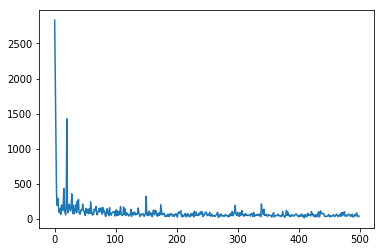

In [33]:
plt.figure()
plt.plot(losses_4)
plt.show()

## Training with embedding size = 4

In [28]:
epoch_range = 500
batch_size_d = 150
batch_size_g = 100
g_learning_rate = 0.0001
d_learning_rate = 0.0001
embedding_size = 4

# Defining the models
gen_5 = generator(length, embedding_size).cuda()
disc_5 = discriminator(length).cuda()

# Initialising the weights
gen_5.apply(init_gan_weights)
disc_5.apply(init_gan_weights)

# Setting up the loss criteria
g_criterion = nn.MSELoss()
d_criterion = nn.BCELoss()

# Setting up the Optimizer (Using Adam here)
g_optimizer = torch.optim.Adam(
    gen_5.parameters(), lr=g_learning_rate, weight_decay=0.001)
d_optimizer = torch.optim.Adam(
    disc_5.parameters(), lr=d_learning_rate, weight_decay=0.001)

enc, out, losses_5 = train_gan(disc_5, gen_5, electrode_data_train, d_criterion, g_criterion, 
                             d_optimizer, g_optimizer, epoch_range, batch_size_d, batch_size_g)

epoch [1/500], disc_real_loss:0.0000, disc_fake_loss:0.6952, gen_loss:2631.2805
epoch [2/500], disc_real_loss:0.0000, disc_fake_loss:0.1758, gen_loss:1612.8105
epoch [3/500], disc_real_loss:0.0000, disc_fake_loss:2.2439, gen_loss:720.6031
epoch [4/500], disc_real_loss:0.0009, disc_fake_loss:10.0208, gen_loss:323.1881
epoch [5/500], disc_real_loss:0.0003, disc_fake_loss:7.4646, gen_loss:175.2804
epoch [6/500], disc_real_loss:0.0333, disc_fake_loss:3.2215, gen_loss:324.1769
epoch [7/500], disc_real_loss:0.0210, disc_fake_loss:3.2679, gen_loss:200.7960
epoch [8/500], disc_real_loss:0.0268, disc_fake_loss:3.0907, gen_loss:97.8636
epoch [9/500], disc_real_loss:0.1594, disc_fake_loss:1.5914, gen_loss:83.7513
epoch [10/500], disc_real_loss:0.5004, disc_fake_loss:1.1262, gen_loss:144.2437
epoch [11/500], disc_real_loss:0.3635, disc_fake_loss:1.0811, gen_loss:59.1752
epoch [12/500], disc_real_loss:0.4139, disc_fake_loss:1.0340, gen_loss:198.6464
epoch [13/500], disc_real_loss:0.5194, disc_fake_

epoch [104/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:149.4934
epoch [105/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:62.1153
epoch [106/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:59.5511
epoch [107/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:109.8202
epoch [108/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:62.4652
epoch [109/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:238.9330
epoch [110/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:70.4983
epoch [111/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:50.5652
epoch [112/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:58.2099
epoch [113/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:67.3635
epoch [114/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:288.8020
epoch [115/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:70.9586
epoch [116/500], disc_real_loss:0.69

epoch [207/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:105.1061
epoch [208/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:131.1410
epoch [209/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:43.3419
epoch [210/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:87.9903
epoch [211/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:48.4796
epoch [212/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:62.2555
epoch [213/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:72.5179
epoch [214/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:46.4139
epoch [215/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:99.3418
epoch [216/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:95.4544
epoch [217/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:27.3189
epoch [218/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:61.5146
epoch [219/500], disc_real_loss:0.6931

epoch [310/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:51.2193
epoch [311/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:48.0835
epoch [312/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:67.2511
epoch [313/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:46.8229
epoch [314/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:119.2439
epoch [315/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:46.3818
epoch [316/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:68.1106
epoch [317/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:50.6237
epoch [318/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:52.8449
epoch [319/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:75.0839
epoch [320/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:55.8738
epoch [321/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:56.5317
epoch [322/500], disc_real_loss:0.6931,

epoch [413/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:54.6105
epoch [414/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:35.4468
epoch [415/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:61.8270
epoch [416/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:110.6328
epoch [417/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:62.8369
epoch [418/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:48.1567
epoch [419/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:61.5410
epoch [420/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:49.2233
epoch [421/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:94.0039
epoch [422/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:104.5513
epoch [423/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:77.0229
epoch [424/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:150.5242
epoch [425/500], disc_real_loss:0.693

In [29]:
torch.save(gen_5, 'models/visapy/gan_4.pt') #Saving the autoencoder model

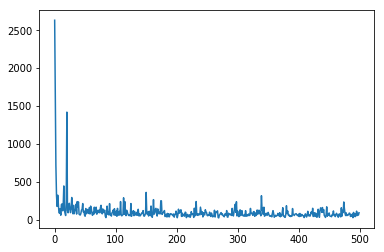

In [30]:
plt.figure()
plt.plot(losses_5)
plt.show()

## Training with embedding size = 2

In [31]:
epoch_range = 500
batch_size_d = 150
batch_size_g = 100
g_learning_rate = 0.0001
d_learning_rate = 0.0001
embedding_size = 2

# Defining the models
gen_6 = generator(length, embedding_size).cuda()
disc_6 = discriminator(length).cuda()

# Initialising the weights
gen_6.apply(init_gan_weights)
disc_6.apply(init_gan_weights)

# Setting up the loss criteria
g_criterion = nn.MSELoss()
d_criterion = nn.BCELoss()

# Setting up the Optimizer (Using Adam here)
g_optimizer = torch.optim.Adam(
    gen_6.parameters(), lr=g_learning_rate, weight_decay=0.001)
d_optimizer = torch.optim.Adam(
    disc_6.parameters(), lr=d_learning_rate, weight_decay=0.001)

enc, out, losses_6 = train_gan(disc_6, gen_6, electrode_data_train, d_criterion, g_criterion, 
                             d_optimizer, g_optimizer, epoch_range, batch_size_d, batch_size_g)

epoch [1/500], disc_real_loss:14.1647, disc_fake_loss:0.8512, gen_loss:2713.2520
epoch [2/500], disc_real_loss:0.0136, disc_fake_loss:0.3339, gen_loss:1966.0889
epoch [3/500], disc_real_loss:0.1132, disc_fake_loss:0.9795, gen_loss:1120.0771
epoch [4/500], disc_real_loss:0.2565, disc_fake_loss:1.5185, gen_loss:432.7958
epoch [5/500], disc_real_loss:0.4904, disc_fake_loss:1.6864, gen_loss:205.8049
epoch [6/500], disc_real_loss:1.0066, disc_fake_loss:0.9687, gen_loss:291.7305
epoch [7/500], disc_real_loss:0.5347, disc_fake_loss:1.1006, gen_loss:197.9506
epoch [8/500], disc_real_loss:0.6881, disc_fake_loss:1.0076, gen_loss:77.7907
epoch [9/500], disc_real_loss:0.7280, disc_fake_loss:0.7836, gen_loss:88.5027
epoch [10/500], disc_real_loss:0.7098, disc_fake_loss:0.7212, gen_loss:139.8466
epoch [11/500], disc_real_loss:0.5796, disc_fake_loss:0.7307, gen_loss:55.8190
epoch [12/500], disc_real_loss:0.7123, disc_fake_loss:0.7484, gen_loss:175.0701
epoch [13/500], disc_real_loss:0.6569, disc_fake

epoch [104/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:296.0478
epoch [105/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:61.5269
epoch [106/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:85.1065
epoch [107/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:140.9050
epoch [108/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:85.6138
epoch [109/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:307.9936
epoch [110/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:83.3657
epoch [111/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:56.3721
epoch [112/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:126.1335
epoch [113/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:62.3227
epoch [114/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:386.6801
epoch [115/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:76.8173
epoch [116/500], disc_real_loss:0.6

epoch [206/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:158.4117
epoch [207/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:112.1605
epoch [208/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:206.4883
epoch [209/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:168.0639
epoch [210/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:143.7875
epoch [211/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:248.0296
epoch [212/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:78.6065
epoch [213/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:160.6159
epoch [214/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:53.0570
epoch [215/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:133.8295
epoch [216/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:156.7127
epoch [217/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:104.8576
epoch [218/500], disc_real_los

epoch [308/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:151.3514
epoch [309/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:83.0181
epoch [310/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:130.5701
epoch [311/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:171.9194
epoch [312/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:107.8254
epoch [313/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:145.4736
epoch [314/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:297.9536
epoch [315/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:85.6213
epoch [316/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:172.3159
epoch [317/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:103.2742
epoch [318/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:74.8455
epoch [319/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:102.8618
epoch [320/500], disc_real_loss

epoch [410/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:83.0913
epoch [411/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:101.1839
epoch [412/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:788.1685
epoch [413/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:78.4432
epoch [414/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:97.1377
epoch [415/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:247.8209
epoch [416/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:212.3987
epoch [417/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:191.6693
epoch [418/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:108.9681
epoch [419/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:72.7360
epoch [420/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:63.0033
epoch [421/500], disc_real_loss:0.6931, disc_fake_loss:0.6931, gen_loss:124.0310
epoch [422/500], disc_real_loss:0

In [32]:
torch.save(gen_6, 'models/visapy/gan_2.pt') #Saving the autoencoder model

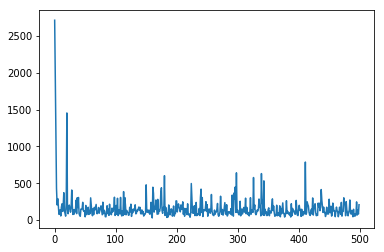

In [33]:
plt.figure()
plt.plot(losses_6)
plt.show()

## -----------------------------------------------------------------------------------

26.285679012537003
2.4445974826812744
-13.966000139713287
-20.654845356941223
-----------------
-0.47019076347351074
6.815380394458771
3.75098517537117
-6.809846580028534
-----------------
4.600436449050903
13.611277103424072
3.3320985436439514
-8.773855566978455
-----------------
4.577629506587982
19.723310708999634
-14.40162456035614
-2.459501266479492
-----------------
4.503844380378723
6.466691613197327
-6.508437871932983
-17.231133103370667
-----------------
16.236461460590363
2.6891775131225586
-9.792131900787354
-10.772267460823059
-----------------
14.776504248380661
27.9939346909523
-18.771763131022453
-0.3959280699491501
-----------------


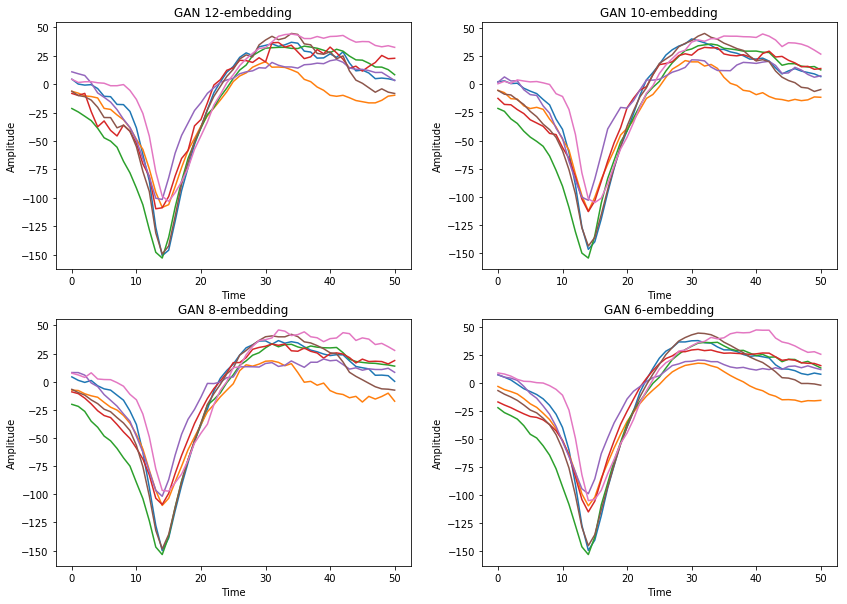

In [34]:
plt.figure(figsize=(14,10))

# n = [1, 30, 45, 50, 65]
n = [11, 290, 3490, 1098, 2707, 9, 871]


for i in n:
    data = electrode_data_test[i, :]
    data = torch.from_numpy(data).float().cuda()
    enc, o_1 = gen_1.forward(data)
    o_1 = (o_1.data).cpu().numpy()
    print(np.sum(np.subtract(electrode_data_test[i, :], o_1)))
    enc, o_2 = gen_2.forward(data)
    o_2 = (o_2.data).cpu().numpy()
    print(np.sum(np.subtract(electrode_data_test[i, :], o_2)))
    enc, o_3 = gen_3.forward(data)
    o_3 = (o_3.data).cpu().numpy()
    print(np.sum(np.subtract(electrode_data_test[i, :], o_3)))
    enc, o_4 = gen_4.forward(data)
    o_4 = (o_4.data).cpu().numpy()
    print(np.sum(np.subtract(electrode_data_test[i, :], o_4)))
    print('-----------------')
    plt.subplot(221)
    plt.plot(o_1)
    plt.title('GAN 12-embedding')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.subplot(222)
    plt.plot(o_2)
    plt.title('GAN 10-embedding')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.subplot(223)
    plt.plot(o_3)
    plt.title('GAN 8-embedding')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.subplot(224)
    plt.plot(o_4)
    plt.title('GAN 6-embedding')
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
plt.show()

# ---------------- LOAD MODELS TO USE -------------------

In [12]:
train_lim = int(0.8*electrode_data.shape[0])
electrode_data_train = electrode_data[:train_lim, :]
electrode_data_test = electrode_data[train_lim:, :]

print("Training Datasize:", electrode_data_train.shape)
print("Test Datasize:", electrode_data_test.shape)

Training Datasize: (15472, 51)
Test Datasize: (3869, 51)


### Loading the models

In [13]:
# Make sure to execute autoencoder model code before executing this

gen_1 = torch.load('models/visapy/gan_12.pt')
gen_2 = torch.load('models/visapy/gan_10.pt')
gen_3 = torch.load('models/visapy/gan_8.pt')
gen_4 = torch.load('models/visapy/gan_6.pt')